In [30]:
import csv
from collections import defaultdict
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit



# Random Analysis 
Random gameplay serves as a control group. It provides a reference point against which the performance of other algorithms can be measured. This control helps ensure that observed differences in performance are due to the algorithms' strategies rather than random chance. 

### Random vs Random 
We are using random vs random to provide a baseline comparison to evaluate the performance of Minimax and Negamax. By comparing against random gameplay, we can assess whether the algorithm is performing better than random chance. 

### Strategy Evaluation 
By looking at the most common win directions and the number of turns to win, this can reveal patterns or tendencies in gameplay that might be exploited or improved upon

### Robustness Testing 
Testing against random opponents helps asses the robustness of the given algorithm. If the algorithm performs well agains random opponents, it suggests it can handle divers and unpredictable strategies effectively. 

Comparing against random opponents can highlight weaknesses in a given algorithm. For example, if said aglorithm consistently loses against random opponents, it may indicate areas for improvement such as better handling of unexpected moves. 

### Player vs Random 
Due to the circular nature connect four twist and turn as well as the new ways that connections can be made with the twist functionality, often winning moves can be overlooked by human players. 

In [31]:
# Filenames

# Random Benchmarking
random_vs_random = "Results/random_vs_random.csv"
minimax_vs_random = "Results/minimax_vs_random.csv"
negamax_vs_random = "Results/negamax_vs_random.csv"

# Greedy Benchmarking 
minimax_vs_greedy = "Results/minimax_vs_greedy.csv"


In [32]:
# Define the new header row

def define_header_row(filename):

    new_header = ["winner","starter","total_turns","win_direction","ab_pruning","t_tables","depth","turn_times","average_turn_time","turn_nodes","average_turn_nodes"]
    


    # Read the existing data from the CSV file
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the existing header
        for row in reader:
            data.append(row)

    # Write the new header and existing data back to the CSV file
    with open(random_vs_random, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the new header
        writer.writerow(new_header)
        
        # Write the existing data
        writer.writerows(data)


def preview_file(filename):
    # Display the updated CSV file
    fileContent = pd.read_csv(filename)
    print(fileContent)



def group_and_plot_by_depth_all_games(filename, plot_type):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Print the DataFrame columns to check if the chosen plot type exists
    print("DataFrame columns:", df.columns)
    
    # Check if the chosen plot type column exists
    if plot_type in df.columns:
        df[plot_type] = df[plot_type].apply(lambda x: eval(x))
    else:
        print(f"'{plot_type}' column not found in the DataFrame.")
        return

    # Group by depth
    depth_groups = df.groupby('depth')

    for depth, group in depth_groups:
        plt.figure()
        for index, row in group.iterrows():
            data = row[plot_type]
            x_vals = []
            y_vals = []

            if row['starter'] == 'Minimax':
                for i in range(len(data)):
                    x_vals.append(i * 2 + 1)  # Minimax's turns are 1, 3, 5, ...
                    y_vals.append(data[i])
            else:
                for i in range(len(data)):
                    x_vals.append(i * 2 + 2)  # Minimax's turns are 2, 4, 6, ...
                    y_vals.append(data[i])

            plt.plot(x_vals, y_vals, marker='o')

        plt.title(f'{plot_type.capitalize()} for Depth {depth}')
        plt.xlabel('Turn')
        plt.ylabel(f'{plot_type.capitalize()}')
        plt.legend()
        plt.show()




def group_and_plot_by_depth_cobf(filename, plot_type):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Print the DataFrame columns to check if the chosen plot type exists
    print("DataFrame columns:", df.columns)
    
    # Check if the chosen plot type column exists
    if plot_type in df.columns:
        df[plot_type] = df[plot_type].apply(lambda x: eval(x))
    else:
        print(f"'{plot_type}' column not found in the DataFrame.")
        return

    # Group by depth
    depth_groups = df.groupby('depth')

    for depth, group in depth_groups:
        fig, ax = plt.subplots(figsize=(8, 6))  # Create a single subplot
        x_vals_all = []
        y_vals_all = []

        for index, row in group.iterrows():
            data = row[plot_type]
            x_vals = []
            y_vals = []

            if row['starter'] == 'Minimax':
                for i in range(len(data)):
                    x_vals.append(i * 2 + 1)  # Minimax's turns are 1, 3, 5, ...
                    y_vals.append(data[i])
            else:
                for i in range(len(data)):
                    x_vals.append(i * 2 + 2)  # Minimax's turns are 2, 4, 6, ...
                    y_vals.append(data[i])

            x_vals_all.extend(x_vals)
            y_vals_all.extend(y_vals)

        # Fit polynomial regression model
        degree = 3  # Define degree of polynomial
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        X = np.array(x_vals_all).reshape(-1, 1)
        model.fit(X, y_vals_all)
        y_pred = model.predict(X)

        # Plot the curve of best fit
        x_range = np.linspace(min(x_vals_all), max(x_vals_all), 100)
        y_range = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_range, linestyle='--', color='red', label='Curve of Best Fit')

        # Plot individual game data
        ax.scatter(x_vals_all, y_vals_all, marker='o', label=f"{plot_type.capitalize()} Data")

        # Set titles and labels
        ax.set_title(f'Curve of Best Fit for Depth {depth}')
        ax.set_xlabel('Turn')
        ax.set_ylabel(f'{plot_type.capitalize()}')
        ax.legend()

        plt.tight_layout()  # Adjust layout to prevent overlapping
        plt.show()







In [33]:
define_header_row(minimax_vs_random)
preview_file(minimax_vs_random)


     winner  starter  total_turns win_direction  ab_pruning  t_tables  depth  \
0   Minimax   Random            8    horizontal        True      True      5   
1   Minimax   Random           14      vertical        True      True      5   
2   Minimax   Random            8    horizontal        True      True      5   
3   Minimax  Minimax           11    horizontal        True      True      5   
4   Minimax  Minimax           15      vertical        True      True      5   
..      ...      ...          ...           ...         ...       ...    ...   
58  Minimax   Random           12    horizontal        True      True      5   
59  Minimax   Random           14      vertical        True      True      5   
60  Minimax  Minimax           15      vertical        True      True      4   
61  Minimax   Random           18      vertical        True      True      4   
62  Minimax   Random           16      vertical        True      True      4   

                                       

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


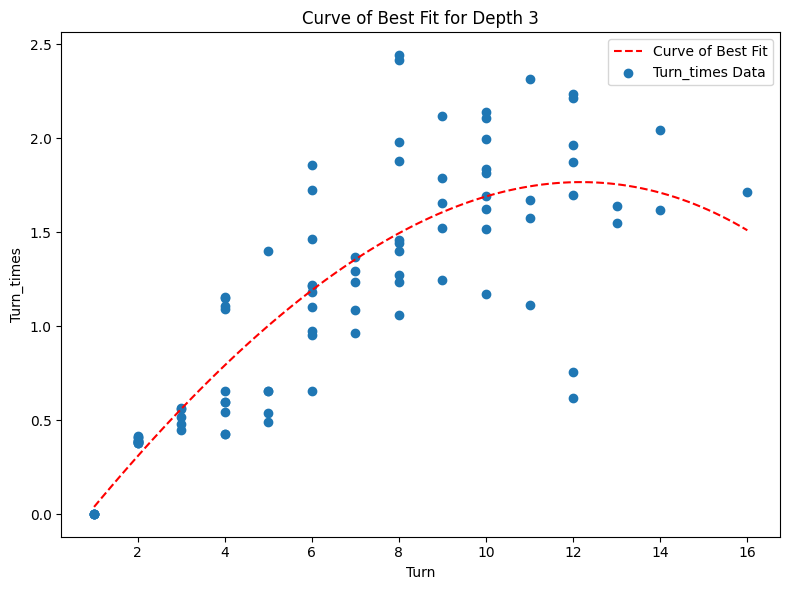

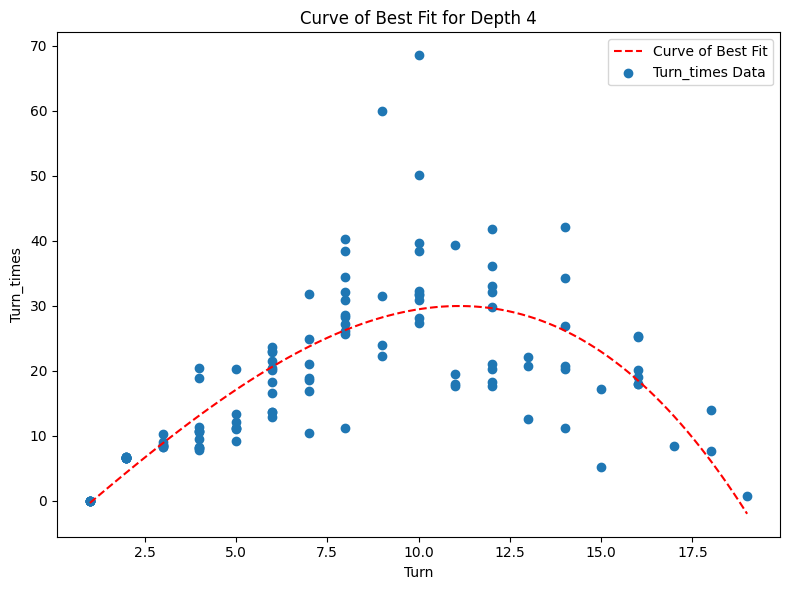

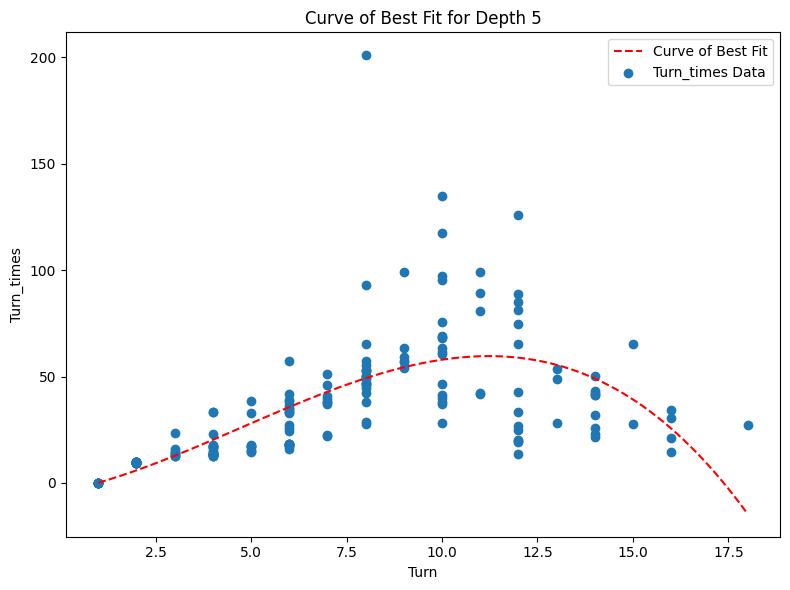

In [48]:
group_and_plot_by_depth_cobf(minimax_vs_random, 'turn_times')

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


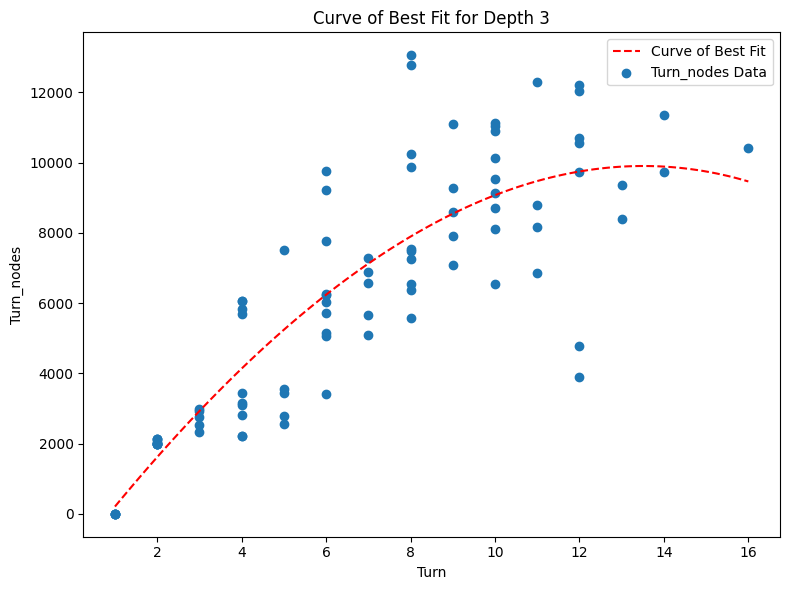

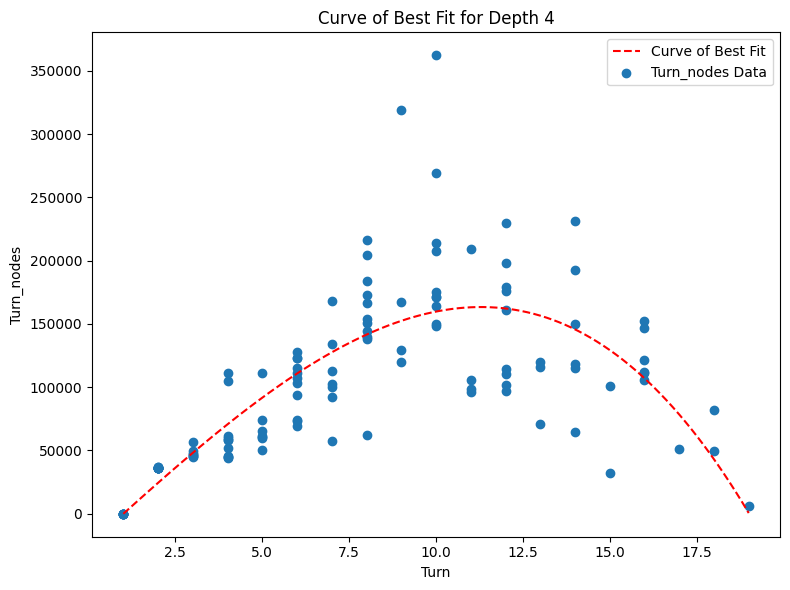

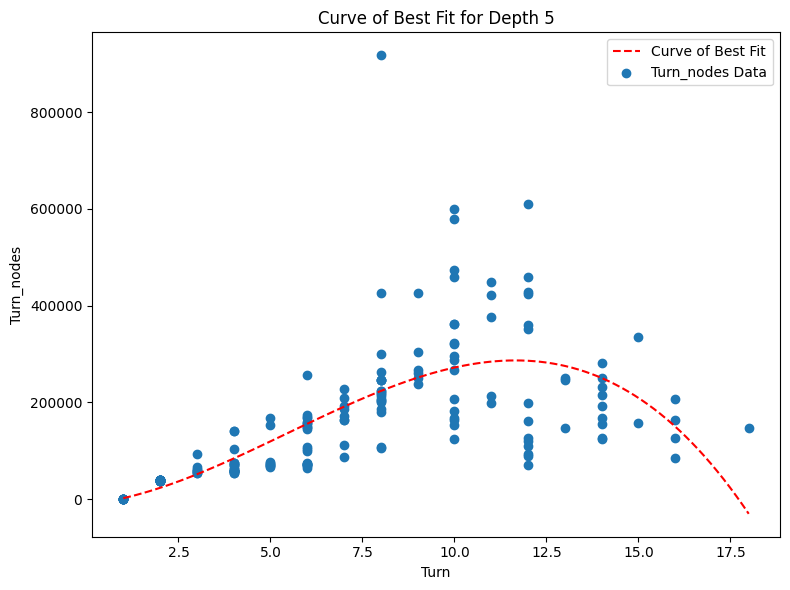

In [35]:
group_and_plot_by_depth_cobf(minimax_vs_random, "turn_nodes")

In [36]:
def group_and_plot_by_performance(filename, plot_type_main, plot_type_sub):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Print the DataFrame columns to check if the chosen plot type exists
    print("DataFrame columns:", df.columns)
    
    # Convert the boolean columns from strings to actual booleans
    df['ab_pruning'] = df['ab_pruning'].astype(bool)
    df['t_tables'] = df['t_tables'].astype(bool)
    
    # Check if the chosen plot type columns exist
    if plot_type_main in df.columns and plot_type_sub in df.columns:
        df[plot_type_main] = df[plot_type_main].apply(lambda x: eval(x))
        df[plot_type_sub] = df[plot_type_sub].apply(lambda x: eval(x))
    else:
        print(f"'{plot_type_main}' or '{plot_type_sub}' column not found in the DataFrame.")
        return

    # Create groups manually
    groups = {
        'True_True': df[(df['ab_pruning'] == True) & (df['t_tables'] == True)],
        'True_False': df[(df['ab_pruning'] == True) & (df['t_tables'] == False)],
        'False_True': df[(df['ab_pruning'] == False) & (df['t_tables'] == True)],
        'False_False': df[(df['ab_pruning'] == False) & (df['t_tables'] == False)]
    }

    for group_name, group in groups.items():
        if group.empty:
            continue
        
        for depth in group['depth'].unique():
            depth_group = group[group['depth'] == depth]
            
            fig, axs = plt.subplots(2, 1, figsize=(10, 12))
            
            for index, row in depth_group.iterrows():
                data_main = row[plot_type_main]
                data_sub = row[plot_type_sub]
                x_vals_main = []
                y_vals_main = []
                x_vals_sub = []
                y_vals_sub = []

                if row['starter'] == 'Minimax':
                    for i in range(len(data_main)):
                        x_vals_main.append(i * 2 + 1)  # Minimax's turns are 1, 3, 5, ...
                        y_vals_main.append(data_main[i])
                        x_vals_sub.append(i * 2 + 1)
                        y_vals_sub.append(data_sub[i])
                else:
                    for i in range(len(data_main)):
                        x_vals_main.append(i * 2 + 2)  # Minimax's turns are 2, 4, 6, ...
                        y_vals_main.append(data_main[i])
                        x_vals_sub.append(i * 2 + 2)
                        y_vals_sub.append(data_sub[i])

                axs[0].plot(x_vals_main, y_vals_main, marker='o', label=f"Game {index + 1}")
                axs[1].plot(x_vals_sub, y_vals_sub, marker='o', label=f"Game {index + 1}")

            # Extract the ab_pruning and t_tables values from the group name
            ab_pruning, t_tables = group_name.split('_')
            
            axs[0].set_title(f'{plot_type_main.capitalize()} for ab_pruning = {ab_pruning}, transposition tables = {t_tables}, depth = {depth}')
            axs[0].set_xlabel('Turn')
            axs[0].set_ylabel(f'{plot_type_main.capitalize()}')
            axs[0].legend()

            axs[1].set_title(f'{plot_type_sub.capitalize()} for ab_pruning = {ab_pruning}, transposition tables = {t_tables}, depth = {depth}')
            axs[1].set_xlabel('Turn')
            axs[1].set_ylabel(f'{plot_type_sub.capitalize()}')
            axs[1].legend()
            
            plt.tight_layout()
            plt.show()



In [37]:
def calculate_and_print_averages(filename):
    # Read the CSV file into a DataFrame with the provided header
    new_header = ["winner","starter","total_turns","win_direction","ab_pruning","t_tables","depth","turn_times","average_turn_time","turn_nodes","average_turn_nodes"]
    df = pd.read_csv(filename, names=new_header, header=0)
    
    # Print the column names to check if they match the new header
    print("DataFrame columns:", df.columns)

    # Convert the boolean columns from strings to actual booleans
    df['ab_pruning'] = df['ab_pruning'].astype(bool)
    df['t_tables'] = df['t_tables'].astype(bool)

    # Convert the string representations of lists into actual lists
    df['turn_times'] = df['turn_times'].apply(lambda x: eval(x))
    df['turn_nodes'] = df['turn_nodes'].apply(lambda x: eval(x))

    # Create groups manually
    groups = {
        'True_True': df[(df['ab_pruning'] == True) & (df['t_tables'] == True)],
        'True_False': df[(df['ab_pruning'] == True) & (df['t_tables'] == False)],
        'False_True': df[(df['ab_pruning'] == False) & (df['t_tables'] == True)],
        'False_False': df[(df['ab_pruning'] == False) & (df['t_tables'] == False)]
    }

    for group_name, group in groups.items():
        if group.empty:
            continue

        print(f"Group: {group_name}")
        
        for depth in group['depth'].unique():
            depth_group = group[group['depth'] == depth]

            total_turns = sum(depth_group['turn_times'].apply(len))
            total_nodes = sum([sum(nodes) for nodes in depth_group['turn_nodes']])
            total_time = sum([sum(times) for times in depth_group['turn_times']])

            avg_nodes_per_turn = total_nodes / total_turns
            avg_time_per_turn = total_time / total_turns

            print(f"Depth {depth}:")
            print(f"  Average nodes evaluated per turn: {avg_nodes_per_turn:.2f}")
            print(f"  Average time taken per turn: {avg_time_per_turn:.2f} seconds")
            print()

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


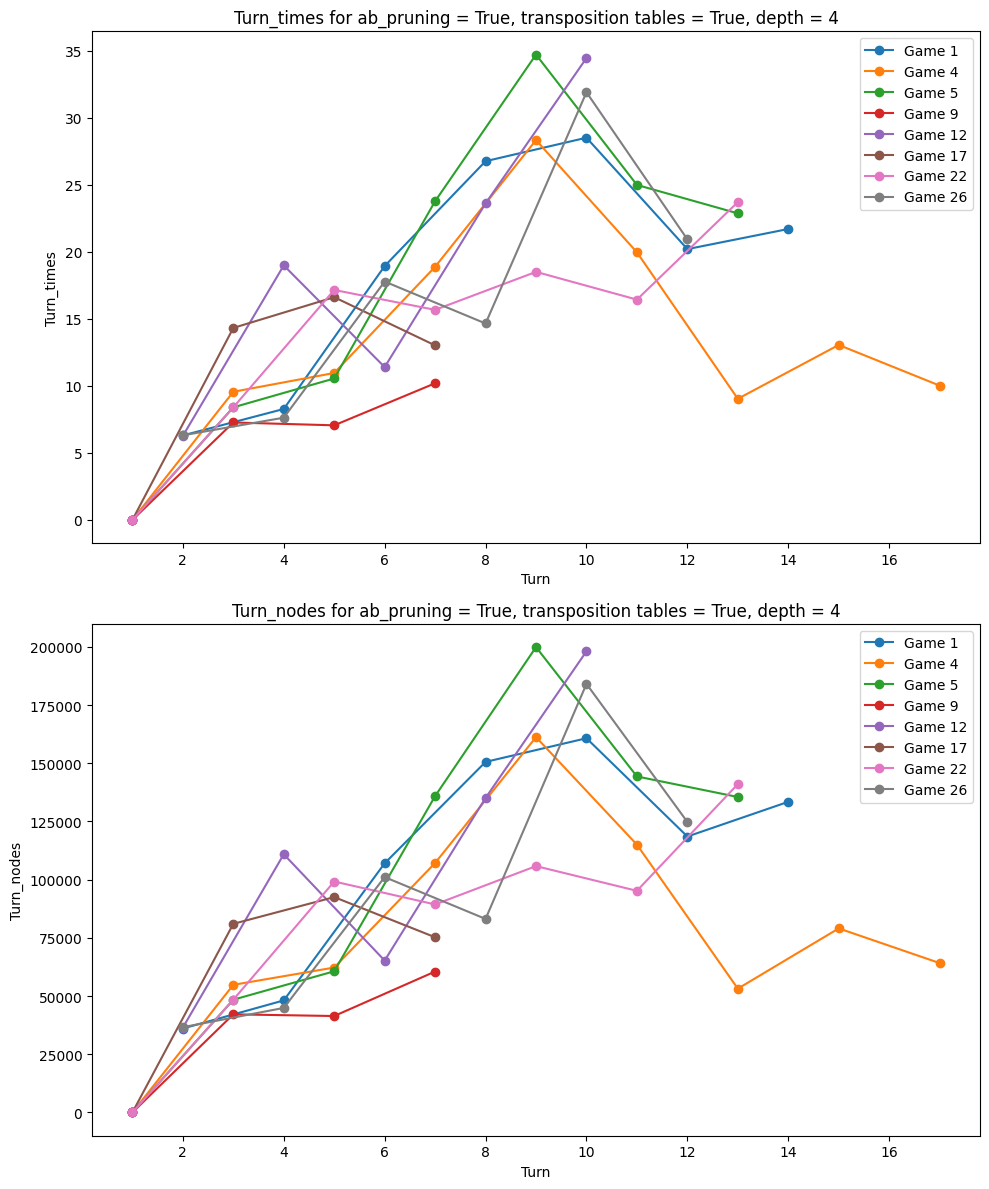

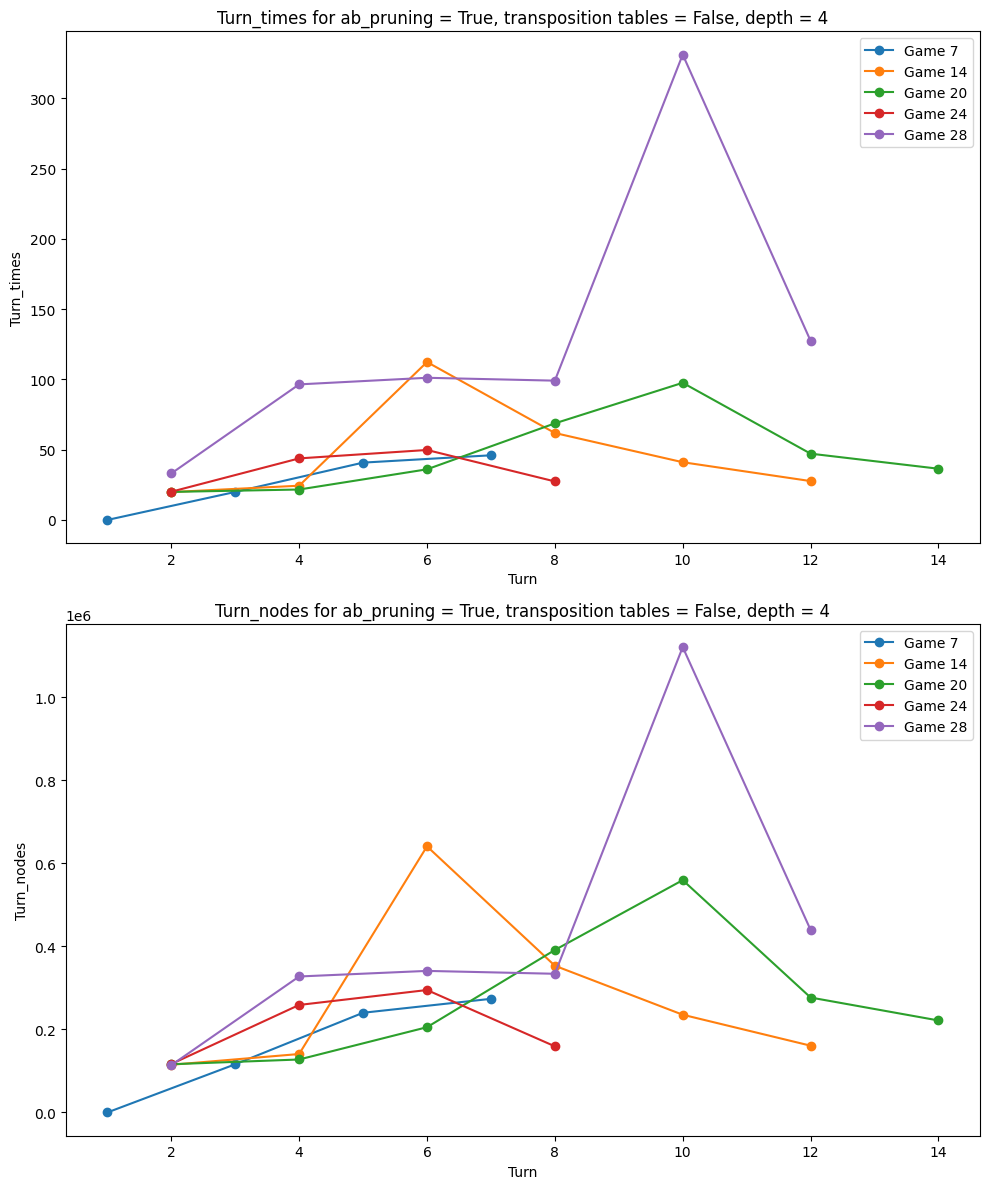

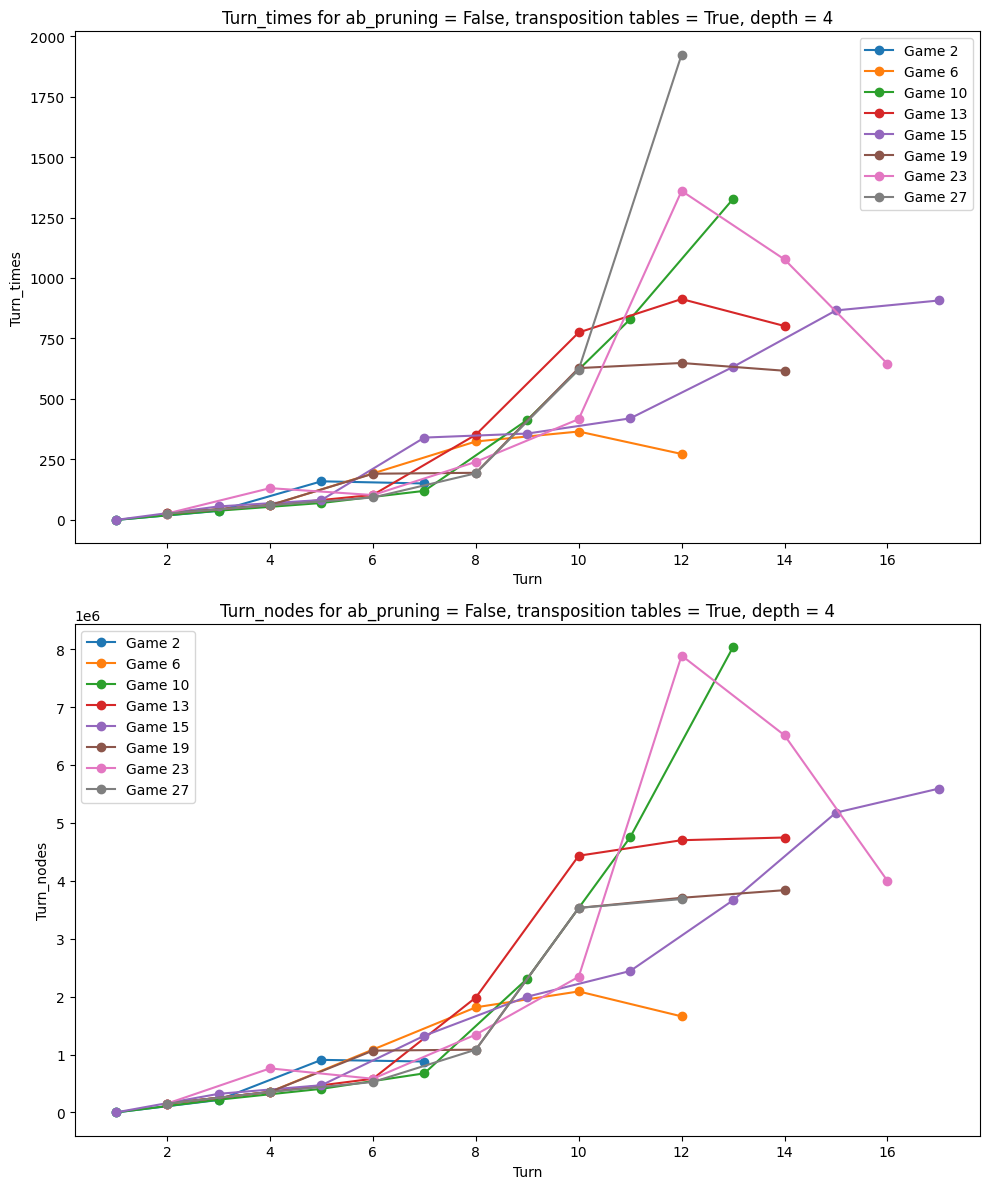

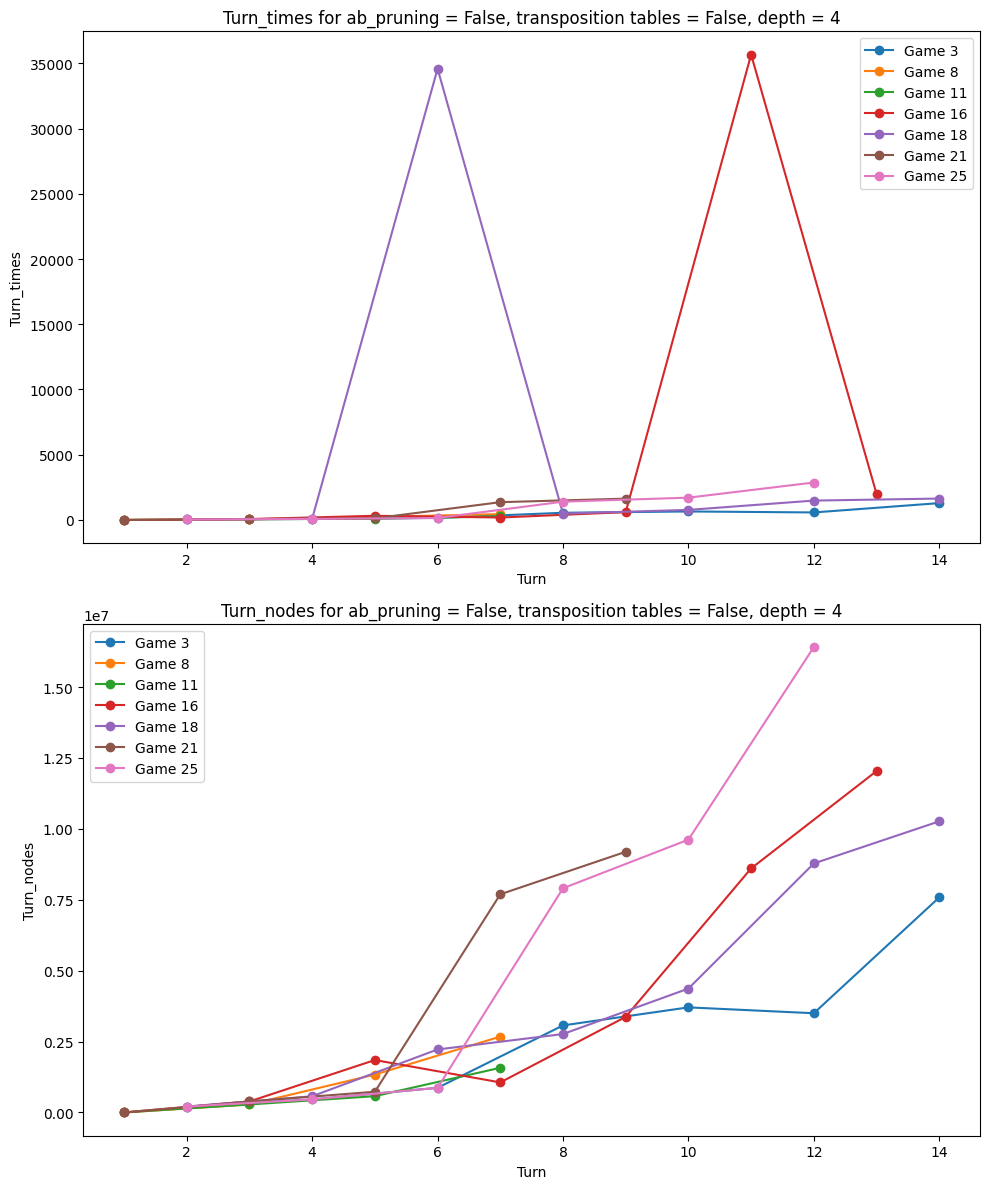

In [38]:
group_and_plot_by_performance('Results/minimax_vs_random_abp_tt.csv', 'turn_times', 'turn_nodes')

In [45]:
calculate_and_print_averages('Results/minimax_vs_random_abp_tt.csv')

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')
Group: True_True
Depth 4:
  Average nodes evaluated per turn: 87102.08
  Average time taken per turn: 15.06 seconds

Group: True_False
Depth 4:
  Average nodes evaluated per turn: 284615.78
  Average time taken per turn: 61.14 seconds

Group: False_True
Depth 4:
  Average nodes evaluated per turn: 2039863.09
  Average time taken per turn: 377.19 seconds

Group: False_False
Depth 4:
  Average nodes evaluated per turn: 3401430.17
  Average time taken per turn: 2296.83 seconds



In [46]:
def calculate_win_rates(filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Convert the depth column to string to avoid confusion during grouping
    df['depth'] = df['depth'].astype(str)
    
    # Group by depth
    depth_groups = df.groupby('depth')
    
    win_rates = {}
    
    for depth, group in depth_groups:
        total_games = len(group)
        minimax_wins = len(group[group['winner'] == 'Minimax'])
        greedy_wins = len(group[group['winner'] == 'Greedy'])
        
        win_rates[depth] = {
            'total_games': total_games,
            'minimax_wins': minimax_wins,
            'greedy_wins': greedy_wins,
            'minimax_win_rate': minimax_wins / total_games if total_games > 0 else 0,
            'greedy_win_rate': greedy_wins / total_games if total_games > 0 else 0
        }
    
    return win_rates

def plot_win_rates(win_rates):
    depths = sorted(win_rates.keys(), key=lambda x: int(x))  # Sort depths numerically
    
    minimax_win_rates = [win_rates[depth]['minimax_win_rate'] for depth in depths]
    greedy_win_rates = [win_rates[depth]['greedy_win_rate'] for depth in depths]
    
    x = range(len(depths))
    
    bar_width = 0.35  # Width of the bars
    
    plt.figure(figsize=(12, 8))
    
    plt.bar(x, greedy_win_rates, width=bar_width, label='Greedy Win Rate', color='red', align='center')
    plt.bar([i + bar_width for i in x], minimax_win_rates, width=bar_width, label='Minimax Win Rate', color='blue', align='center')
    
    plt.xticks([i + bar_width / 2 for i in x], depths)
    plt.xlabel('Depth')
    plt.ylabel('Win Rate')
    plt.title('Win Rates by Depth')
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()

{'2': {'total_games': 150, 'minimax_wins': 138, 'greedy_wins': 12, 'minimax_win_rate': 0.92, 'greedy_win_rate': 0.08}, '3': {'total_games': 140, 'minimax_wins': 139, 'greedy_wins': 1, 'minimax_win_rate': 0.9928571428571429, 'greedy_win_rate': 0.007142857142857143}, '4': {'total_games': 140, 'minimax_wins': 120, 'greedy_wins': 20, 'minimax_win_rate': 0.8571428571428571, 'greedy_win_rate': 0.14285714285714285}, '5': {'total_games': 141, 'minimax_wins': 132, 'greedy_wins': 9, 'minimax_win_rate': 0.9361702127659575, 'greedy_win_rate': 0.06382978723404255}}


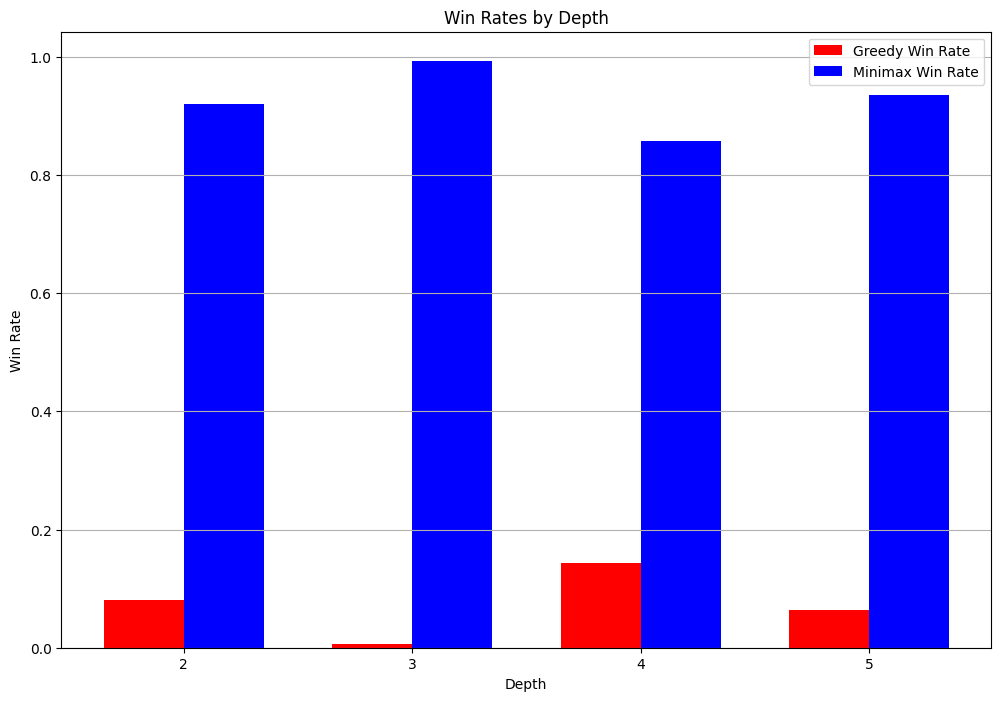

In [47]:
win_rates = calculate_win_rates("Results/minimax_vs_greedy.csv")

print(win_rates)

plot_win_rates(win_rates)
